# ACCESS salinity

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33987/status,
Dashboard: /proxy/33987/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35113,Workers: 28
Dashboard: /proxy/33987/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:40613,Total threads: 1
Dashboard: /proxy/37693/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:34557,


In [4]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))#[-66:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
# Shelf mask
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds[['so', 'volcello']].sel(yh=shelf_mask['yh'])
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
#Time invariant variables
depth = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
areaC = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

In [10]:
# Salinity variable
saltC = cont['so']
saltM = melt['so']

## Bottom salinity

In [11]:
bottom_mask_saltC = saltC.where(~np.isfinite(saltC.shift({'z_l': -1})))
bottom_mask_saltC = ~np.isnan(bottom_mask_saltC)

In [12]:
bottom_mask_saltM = saltM.where(~np.isfinite(saltM.shift({'z_l': -1})))
bottom_mask_saltM = ~np.isnan(bottom_mask_saltM)

In [13]:
botsalt_cont = saltC.where(bottom_mask_saltC).sum(dim='z_l')
botsalt_pert = saltM.where(bottom_mask_saltM).sum(dim='z_l')

In [14]:
botsalt_cont = botsalt_cont.mean(dim=['xh','yh'])
botsalt_pert = botsalt_pert.mean(dim=['xh','yh'])

In [15]:
botsalt_cont = botsalt_cont.load()
botsalt_pert = botsalt_pert.load()

In [16]:
botsalt_anom = botsalt_pert - botsalt_cont
botsalt_anom = botsalt_anom.load()

In [25]:
botsalt_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_botsalt_anom.nc')

Text(0.5, 1.0, 'Pan01 Time Series of Bottom Salinity on Shelf')

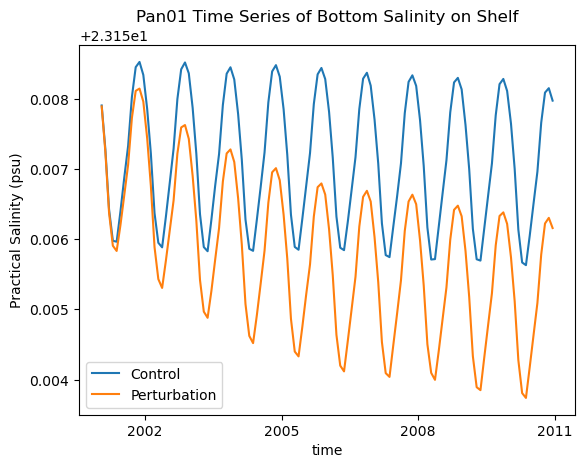

In [17]:
botsalt_cont.plot(label="Control")
botsalt_pert.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Practical Salinity (psu)")
plt.legend(loc="lower left")
plt.title("Pan01 Time Series of Bottom Salinity on Shelf")

#### Mapping bottom salinity

In [18]:
botsalt_cont_map = saltC.where(bottom_mask_saltC).sum(dim='z_l').mean(dim='time')
botsalt_pert_map = saltM.where(bottom_mask_saltM).sum(dim='z_l').mean(dim='time')
botsalt_anom_ave = botsalt_pert_map - botsalt_cont_map

In [19]:
botsalt_anom_ave = botsalt_anom_ave.load()

In [20]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [21]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

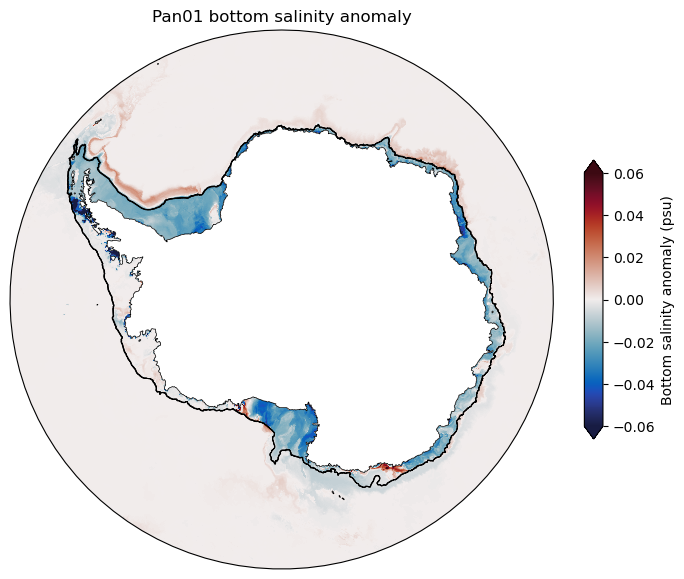

In [24]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Adding the model land mask
land.plot.contourf(ax=ax, x="xh", y="yh", colors="white",
    zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)

# Adding the model coastline
land.fillna(0).plot.contour(ax=ax, x="xh", y="yh", colors="k",
    levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)

# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

botsalt_anom_ave.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom salinity anomaly (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Pan01 bottom salinity anomaly");

## Comparing to ACCESS

In [26]:
pan01_botsalt_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_botsalt_anom.nc', chunks = 'auto')
acc_botsalt_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/accessom201_botsalt_anom.nc', chunks = 'auto')

In [27]:
pan01_botsalt_anom_new = pan01_botsalt_anom.to_series()
acc_botsalt_new = acc_botsalt_anom.to_series()

In [28]:
import pandas as pd

In [29]:
# Slice 1910–1919 and 2001–2010
pan01_botsalt_anom_new = pan01_botsalt_anom_new['2001-01-01':'2010-10-16']
acc_botsalt_new = acc_botsalt_new['1910-01-01':'1919-10-16']

# Reset index to normalized months
pan01_botsalt_anom_new.index = range(1, len(pan01_botsalt_anom_new)+1)
acc_botsalt_new.index = range(1, len(acc_botsalt_new)+1)

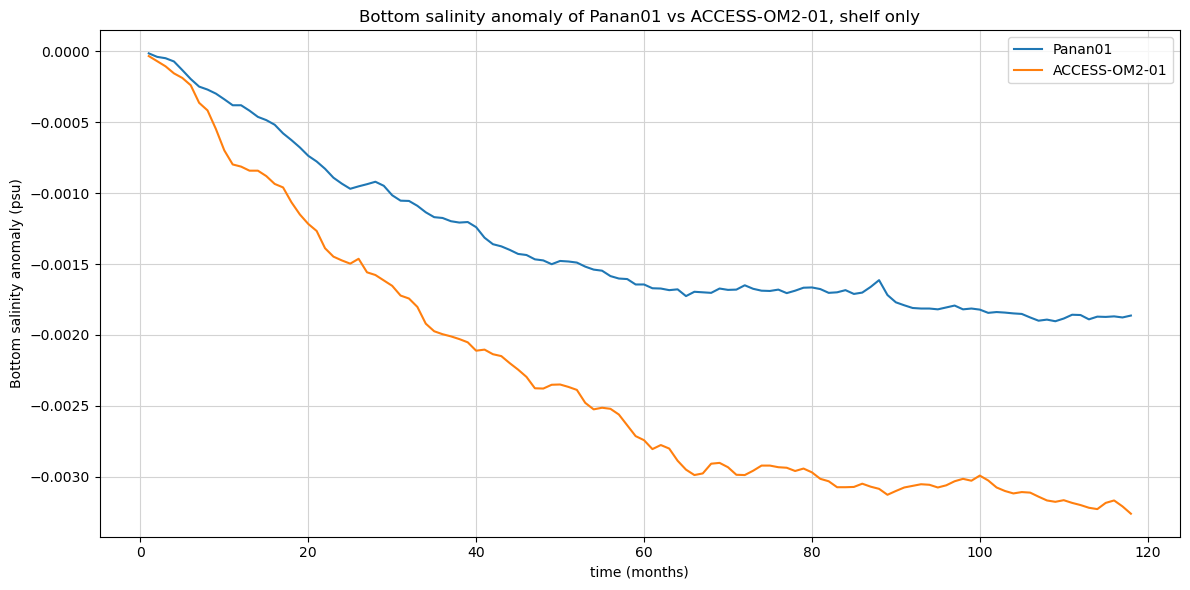

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(pan01_botsalt_anom_new.index, pan01_botsalt_anom_new.values, label='Panan01')
plt.plot(acc_botsalt_new.index, acc_botsalt_new.values, label='ACCESS-OM2-01')
plt.xlabel('time (months)')
plt.ylabel("Bottom salinity anomaly (psu)")
plt.title('Bottom salinity anomaly of Panan01 vs ACCESS-OM2-01, shelf only')
plt.legend()
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()